## Enem e NLP

Notebook implementando a classificação textual da área do conhecimento de uma questão do enem a partir do seu texto.



## Importando bibliotecas

In [1]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=19292dded5b7c3c6229284adcd5066b80768cb726aaccee1114e5490072c0d3d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=431d5cd92ec9de3449cf4bac737703c3f6b3935255435f73b7668a68cd016c98
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
# General Libraries
import pandas as pd
import numpy as np

# Machine Learning & Natural Language Processing
import re

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from nltk.corpus import stopwords
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import TruncatedSVD 

import umap

## Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Importando dados

In [100]:
len(questoes_enem_df)

3843

In [3]:
questoes_enem_df = pd.read_json('enem_questoes.json', orient='record')

In [10]:
print( questoes_enem_df['area'][0] )
print( questoes_enem_df['enunciado'][0] )

ciências humanas

QUESTÃO 01
Sentimos que toda satisfação de nossos desejos 
advinda do mundo assemelha-se à esmola que mantém 
hoje o mendigo vivo, porém prolonga amanhã a sua 
fome. A resignação, ao contrário, assemelha-se à 
fortuna herdada: livra o herdeiro para sempre de todas 
as preocupações.
SCHOPENHAUER, A. Aforismo para a sabedoria da vida. São Paulo: Martins Fontes, 2005.
O trecho destaca uma ideia remanescente de uma 
���������������������������������������������������������
se mostra indissociavelmente ligada à
A consagração de relacionamentos afetivos.
B administração da independência interior.
C fugacidade do conhecimento empírico. 
D liberdade de expressão religiosa. 
E busca de prazeres efêmeros.


### Tratamento dos dados

In [68]:
def tratar_dados_enem(s):

  # Lowercase
  s = s.lower()

  # Remove <?> character
  s = re.sub("�", "", s)

  # Substituindo todos os números por um token único
  s = re.sub("(\d+.)+", " <TOKENNUMERO> ", s)

  # Remover nome das áreas
  s = re.sub("ciências humanas e suas tecnologias", " ", s)
  s = re.sub("ciências da natureza e suas tecnologias", " ", s)
  s = re.sub("linguagens, códigos e suas tecnologias", " ", s)
  s = re.sub("matemática e suas tecnologias", " ", s)

  return s

In [69]:
# Selecionando apenas questçoes com area definida
questoes_enem_df = questoes_enem_df.query("area != 'UNDEFINED'")

# Remove <?> character
questoes_enem_df['enunciado_tratado'] = questoes_enem_df['enunciado'].apply( tratar_dados_enem )

In [70]:
custom_stopwords = ['questão', 'caderno', 
                    'página', 'adaptado', 'fragmento', 'disponível',
                    'www', 'http', 'acesso', 
                    'lc', 'cn', 'ch', 'mt'
                    ]

## EDA 

## Separando treino e teste

In [71]:
X = questoes_enem_df['enunciado_tratado']
y = questoes_enem_df['area']

X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, random_state=214 )

In [72]:
y_labels = y_train.unique()
y_labels.sort()

### Visualização 2D com TF-IDF & UMAP

In [89]:
%%time
pipe_red = Pipeline( [( "tfidf_vec", TfidfVectorizer(min_df=0.05, max_df=0.6,
                                                     stop_words=stopwords.words("portuguese")+custom_stopwords+['tokennumero'],
                                                     ngram_range=(1,2)
                                                     ) ),
                      ( "umap_red", umap.UMAP(n_neighbors=15, metric='hellinger', verbose=3) ),
                      ],
                     verbose=3 
                    )

X_train_2d = pipe_red.fit_transform(X_train)

[Pipeline] ......... (step 1 of 2) Processing tfidf_vec, total=   0.8s
UMAP(angular_rp_forest=True, metric='hellinger', verbose=3)
Thu Nov 25 08:42:41 2021 Construct fuzzy simplicial set
Thu Nov 25 08:42:46 2021 Finding Nearest Neighbors
Thu Nov 25 08:42:47 2021 Finished Nearest Neighbor Search
Disconnection_distance = 1 has removed 4427246 edges.  This is not a problem as no vertices were disconnected.
Thu Nov 25 08:42:47 2021 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Nov 25 08:42:57 2021 Finished embedding
[Pipeline] .......... (step 2 of 2) Processing umap_red, total=  15.9s
CPU times: user 22.6 s, sys: 230 ms, total: 22.8 s
Wall time: 16.7 s


Text(0.5, 1.0, '2D visualization with UMAP')

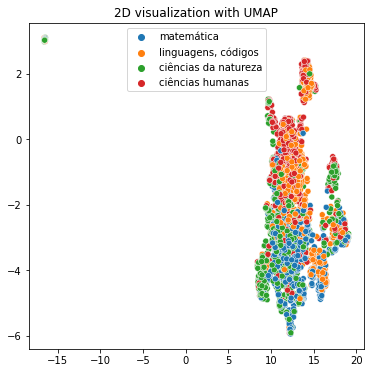

In [90]:
X_train_red_df = pd.DataFrame( data={'x':X_train_2d[:,0], 'y':X_train_2d[:,1], 'area':y_train} )
labels = y_train.unique()

fig, ax = plt.subplots( figsize=(6,6) )

ax = sns.scatterplot(data=X_train_red_df, x='x', y='y', hue='area', 
                     hue_order=labels, 
                     ax=ax 
                    )

plt.legend(loc = "upper center")
ax.set_xlabel("")
ax.set_ylabel("")

ax.set_title("2D visualization with UMAP")

### WordClouds

In [91]:
size_x, size_y = 800, 800
x, y = np.ogrid[:size_x, :size_y]

circ_mask = (x - size_x/2) ** 2 + (y - size_y/2) ** 2 > (size_x/2.5) ** 2
circ_mask = 255 * circ_mask.astype(int)

In [102]:
X_train_tfidf = pipe_red["tfidf_vec"].transform(X_train)

X_train_tfidf_df = pd.DataFrame( X_train_tfidf.todense(), columns=pipe_red["tfidf_vec"].get_feature_names_out() )

X_train_tfidf_df += 10e-8 # evitar divisão por zero (?)

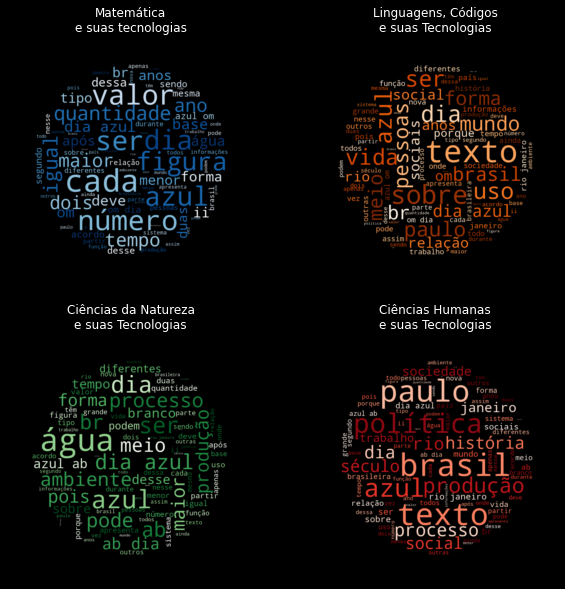

In [93]:
fig, ax = plt.subplots( nrows = 2, ncols = 2, figsize=(10,10) )
ax = ax.flatten()

cmaps = ['Blues', 'Oranges', 'Greens', 'Reds']
titles = ["Matemática\ne suas tecnologias", 
          "Linguagens, Códigos\ne suas Tecnologias", 
          "Ciências da Natureza\ne suas Tecnologias", 
          "Ciências Humanas\ne suas Tecnologias"]

fig.patch.set_facecolor('black')

for i in range(4):
  wc = WordCloud(background_color="black", mask=circ_mask,
                 max_font_size=100,
                 colormap=cmaps[i],
                 random_state=214,
                 max_words=400
                 )
  wc.generate_from_frequencies(X_train_tfidf_df[ (y_train==labels[i]).to_numpy() ].mean(axis=0).to_dict() )

  ax[i].set_title( titles[i], color='white' )
  ax[i].imshow(circ_mask, interpolation="bilinear")
  ax[i].imshow(wc, interpolation="bilinear")
  ax[i].axis("off")

## Classificação com TF-IDF & Random Forest Classifier

In [78]:
pipe_clf = Pipeline( [( "tfidf_vec", TfidfVectorizer( stop_words=stopwords.words("portuguese")+custom_stopwords ) ),
                      ( "tsvd_red", TruncatedSVD (random_state=214) ),
                      ( "rnf_clf", RandomForestClassifier(random_state=214, n_jobs=-1) )
                      ] 
                    )

Pipeline(steps=[('tfidf_vec',
                 TfidfVectorizer(stop_words=['de', 'a', 'o', 'que', 'e', 'é',
                                             'do', 'da', 'em', 'um', 'para',
                                             'com', 'não', 'uma', 'os', 'no',
                                             'se', 'na', 'por', 'mais', 'as',
                                             'dos', 'como', 'mas', 'ao', 'ele',
                                             'das', 'à', 'seu', 'sua', ...])),
                ('tsvd_red', TruncatedSVD(random_state=214)),
                ('rnf_clf',
                 RandomForestClassifier(n_jobs=-1, random_state=214))])

In [79]:
params = { 
           "tfidf_vec__min_df": [ 0.01, 0.05 ],
           
           "tsvd_red__n_components": [100, 200 ],
           
           "rnf_clf__n_estimators":[10, 100, 200],
           "rnf_clf__max_depth":[10, 25, 50],
           "rnf_clf__min_samples_leaf":[1, 4, 10]
          }

grid_search = GridSearchCV(pipe_clf, params, cv=3, scoring="accuracy", 
                           verbose=3, return_train_score=True, n_jobs=-1 )

In [80]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
162 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", li

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vec',
                                        TfidfVectorizer(stop_words=['de', 'a',
                                                                    'o', 'que',
                                                                    'e', 'é',
                                                                    'do', 'da',
                                                                    'em', 'um',
                                                                    'para',
                                                                    'com',
                                                                    'não',
                                                                    'uma', 'os',
                                                                    'no', 'se',
                                                                    'na', 'por',
                                                               

In [81]:
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vec',
                 TfidfVectorizer(min_df=0.01,
                                 stop_words=['de', 'a', 'o', 'que', 'e', 'é',
                                             'do', 'da', 'em', 'um', 'para',
                                             'com', 'não', 'uma', 'os', 'no',
                                             'se', 'na', 'por', 'mais', 'as',
                                             'dos', 'como', 'mas', 'ao', 'ele',
                                             'das', 'à', 'seu', 'sua', ...])),
                ('tsvd_red', TruncatedSVD(n_components=100, random_state=214)),
                ('rnf_clf',
                 RandomForestClassifier(max_depth=25, n_jobs=-1,
                                        random_state=214))])

In [82]:
y_train_pred = cross_val_predict( best_model, X_train, y_train )

Text(0.5, 1.0, 'Confusion Matrix\ndas áreas (validação, cv=3)')

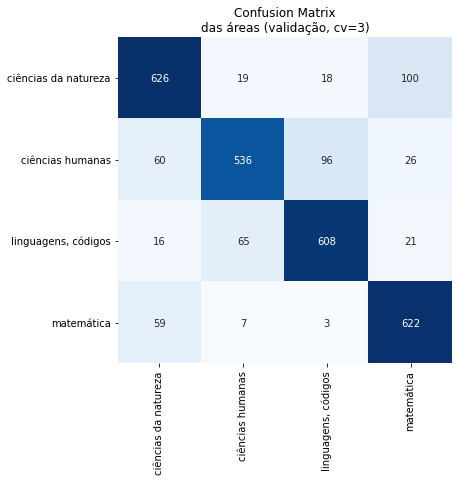

In [83]:
labels = y_train.unique()
confusion_m = confusion_matrix(y_train, y_train_pred, labels=y_labels)

fig, ax = plt.subplots( figsize=(6,6) )

sns.heatmap(confusion_m, annot=True, fmt='d', 
            xticklabels=y_labels, yticklabels=y_labels,
            cmap='Blues', cbar=False,
            ax=ax)

ax.set_title("Confusion Matrix\ndas áreas (validação, cv=3)")

In [96]:
print( classification_report(y_train, y_train_pred) )

                      precision    recall  f1-score   support

ciências da natureza       0.82      0.82      0.82       763
    ciências humanas       0.85      0.75      0.80       718
 linguagens, códigos       0.84      0.86      0.85       710
          matemática       0.81      0.90      0.85       691

            accuracy                           0.83      2882
           macro avg       0.83      0.83      0.83      2882
        weighted avg       0.83      0.83      0.83      2882



### Avaliação final nos dados de Teste

Text(0.5, 1.0, 'Confusion Matrix\ndas áreas (teste)')

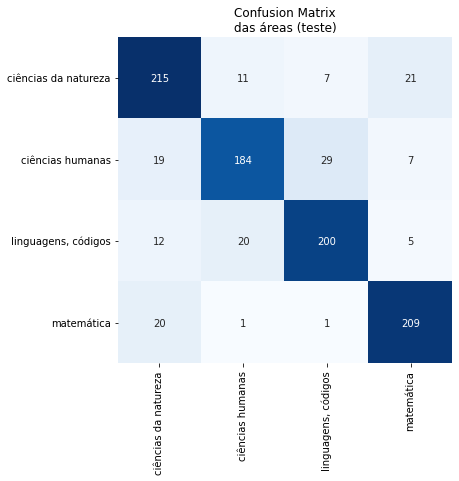

In [84]:
y_test_pred=best_model.predict(X_test)
confusion_m = confusion_matrix(y_test, y_test_pred, labels=y_labels)

fig, ax = plt.subplots( figsize=(6,6) )

sns.heatmap(confusion_m, annot=True, fmt='d', 
            xticklabels=y_labels, yticklabels=y_labels,
            cmap='Blues', cbar=False,
            ax=ax)

ax.set_title("Confusion Matrix\ndas áreas (teste)")

In [97]:
print( classification_report(y_test, y_test_pred) )

                      precision    recall  f1-score   support

ciências da natureza       0.81      0.85      0.83       254
    ciências humanas       0.85      0.77      0.81       239
 linguagens, códigos       0.84      0.84      0.84       237
          matemática       0.86      0.90      0.88       231

            accuracy                           0.84       961
           macro avg       0.84      0.84      0.84       961
        weighted avg       0.84      0.84      0.84       961



## Bônus: Questões customizadas

In [116]:
questoes = ["Qual a área total do polígono?",
            "Pablo Picasso foi um dos maiores artistas...",
            "A Guerra fria foi um período tenso entre as...",
            "Qual o quinto planeta do sistema solar?",
            "Dado um corpo submerso, determine a temperatura final",
            "A principal causa desse tipo de doença é ...",
            "A república brasileira pode ser ...",
            "O poema abaixo escrito por Mário de Andrade retrata...",
            "Na Grécia antiga surge a filosofia, astronomia e matemática",
            "Dado que o pai é careca, qual a probabilidade de o filho também ser?",
            "Quanto à tipologia textual, o banner acima representa",
            "O escritor defende a tese de que o homem deve ser livre",
            ]

y_predicts = best_model.predict(questoes)
y_predicts_proba = best_model.predict_proba(questoes)

In [117]:
for text, y_predict, probas in zip( questoes, y_predicts, y_predicts_proba ):
  print(f"({y_predict}) {text}")

  for proba, label in zip(probas, y_labels):
    print(f"{label} - {proba:.2f};", end=" ")
  print("\n")

(matemática) Qual a área total do polígono?
ciências da natureza - 0.12; ciências humanas - 0.15; linguagens, códigos - 0.06; matemática - 0.67; 

(ciências da natureza) Pablo Picasso foi um dos maiores artistas...
ciências da natureza - 0.47; ciências humanas - 0.10; linguagens, códigos - 0.16; matemática - 0.27; 

(ciências humanas) A Guerra fria foi um período tenso entre as...
ciências da natureza - 0.21; ciências humanas - 0.59; linguagens, códigos - 0.10; matemática - 0.10; 

(ciências da natureza) Qual o quinto planeta do sistema solar?
ciências da natureza - 0.59; ciências humanas - 0.10; linguagens, códigos - 0.09; matemática - 0.22; 

(ciências da natureza) Dado um corpo submerso, determine a temperatura final
ciências da natureza - 0.69; ciências humanas - 0.07; linguagens, códigos - 0.14; matemática - 0.10; 

(ciências da natureza) A principal causa desse tipo de doença é ...
ciências da natureza - 0.52; ciências humanas - 0.12; linguagens, códigos - 0.14; matemática - 0.22